In [1]:
import os
import pandas as pd
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

import shutil
import collections
import math

In [2]:
demo = False

if demo:
    data_dir = d2l.download_extract('cifar10_tiny')
else:
    data_dir = '../data/cifar10_reorg'

In [3]:
batch_size = 32 if demo else 128

In [4]:
transform_train = torchvision.transforms.Compose([
    torchvision.transforms.Resize(40),
    torchvision.transforms.RandomResizedCrop(32, scale=(0.64, 1.0), ratio=(1.0, 1.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]),
])

transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]),
])

# for parameter adjusment
train_ds = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train_valid_test', 'train'), transform=transform_train)
train_iter = torch.utils.data.DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, drop_last=True)
valid_ds = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train_valid_test', 'valid'), transform=transform_test)
valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False, num_workers=4, drop_last=True)

# for training
train_valid_ds = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train_valid_test', 'train_valid'), transform=transform_train)
train_valid_iter = torch.utils.data.DataLoader(train_valid_ds, batch_size, shuffle=True, num_workers=4, drop_last=True)

test_ds = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train_valid_test', 'test'), transform=transform_test)
test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False, num_workers=4, drop_last=False)



In [5]:
test_ds2 = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train_valid_test', 'test'))
test_iter2 = torch.utils.data.DataLoader(test_ds2, batch_size=1, shuffle=False, num_workers=4, drop_last=False)


In [5]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay):
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    loss = nn.CrossEntropyLoss(reduction='none')
    trainer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)

    legend = ['train loss', 'train acc']
    if valid_iter is not None:
        legend.append('valid acc')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], legend=legend)

    num_batches, timer = len(train_iter), d2l.Timer()

    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)

        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            l, acc = d2l.train_batch_ch13(net, X, y, loss, trainer, devices)
            timer.stop()
            metric.add(l, acc, y.shape[0])
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches, (metric[0] / metric[2], metric[1] / metric[2], None))

        if valid_ds is not None:
            net.eval()
            valid_acc = d2l.evaluate_accuracy_gpu(net, valid_iter)
            animator.add(epoch + 1, (None, None, valid_acc))
        
        scheduler.step()

    measures = (f'train loss {metric[0] / metric[2]:.3f}, '
                f'train acc {metric[1] / metric[2]:.3f}')
    if valid_iter is not None:
        measures += f', valid acc {valid_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')


RuntimeError: CUDA error: an illegal memory access was encountered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

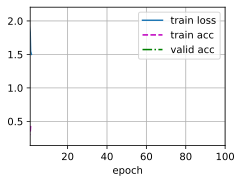

In [6]:
num_epochs = 100
lr = 2e-4
wd = 5e-4
lr_period = 50
lr_decay = 0.1
devices = d2l.try_all_gpus()

# 调参
net = d2l.resnet18(10, 3)
# train(net, train_iter, valid_iter, num_epochs, lr, wd, devices=d2l.try_all_gpus(), lr_period=lr_period, lr_decay=lr_decay)


In [ ]:
preds = []
net.eval()
for X, _ in test_iter:
    y_hat = net(X.to(devices[0]))
    preds.extend(y_hat.argmax(dim=1).type(torch.int32).cpu().numpy())
sorted_ids = list(range(1, len(test_ds) + 1))
sorted_ids.sort(key=lambda x: str(x))

df = pd.DataFrame({ 'id': sorted_ids, 'label': preds})
df['label'] = df['label'].apply(lambda x: train_valid_ds.classes[x])
df.to_csv('submission.csv', index=False)


[1, 2, 3, 4, 5]
[1, 2, 3, 4, 5]
[8, 4, 0, 6, 3]
   id     label
0   1      ship
1   2      deer
2   3  airplane
3   4      frog
4   5       cat
